In [1]:
from matrices import matrix, matrix_v, generate_iupac, matrix_logp, matrix_sa
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

2023-05-25 14:49:19.805101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-25 14:49:19.805163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version: 2.7.2


2023-05-25 14:49:21.531702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-25 14:49:21.531901: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-25 14:49:21.532025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ZPsTP): /proc/driver/nvidia/version does not exist
2023-05-25 14:49:21.850531: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def gd(x, u, sigma):
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (x - u))**2))
    # y = np.multiply(np.power(np.sqrt(2 * np.pi) * sigma, -1), np.exp(-np.power(x - u, 2) / (2 * sigma ** 2)))
    return y

# Epoch = 1
## Normal test

In [ ]:
fname = './log/eval_gtp2_13000000_n_0.log'
nums, valid_num, unique_num, equal_num, valid_unique_num = matrix(fname)

In [ ]:
print(f"Total num: {nums}")
print(f"Valid num: {valid_num}, valid ratio: {valid_num/nums}")
print(f"Unique num: {unique_num}, unique ratio: {unique_num/nums}")
print(f"Equal num: {equal_num}, equal ratio: {equal_num/nums}")
print(f"Valid&unique num: {valid_unique_num}, valid&unique num ratio: {valid_unique_num/nums}")

## Shuffle test

In [ ]:
fname = './log/eval_gtp2_13000000_s_0.log'
nums, valid_num, unique_num, equal_num, valid_unique_num = matrix(fname)

In [ ]:
print(f"Total num: {nums}")
print(f"Valid num: {valid_num}, valid ratio: {valid_num/nums}")
print(f"Unique num: {unique_num}, unique ratio: {unique_num/nums}")
print(f"Equal num: {equal_num}, equal ratio: {equal_num/nums}")
print(f"Valid&unique num: {valid_unique_num}, valid&unique num ratio: {valid_unique_num/nums}")

## Drop test

In [ ]:
drop_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# drop_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
num_list = []
valid_list = []
unique_list = []
valid_unique_list = []
valid_ratio_list = []
for drop in drop_list:
    fname = f'./log/eval_gtp2_13000000_d_0_{drop}.log'
    # nums, valid_num, unique_num, equal_num, valid_unique_num = matrix(fname)
    nums, valid_num, unique_num, equal_num, valid_unique_num = matrix(fname)
    # print(valid_num)
    num_list.append(nums)
    valid_list.append(valid_num)
    unique_list.append(unique_num)
    valid_unique_list.append(valid_unique_num)
    valid_ratio_list.append(valid_num/nums)

In [ ]:
plt.grid()

# plt.figure(figsize=(16,10))

plt.plot(drop_list,valid_ratio_list,label='GraphAKD', marker='o', markersize=10, c='darkcyan')
# plt.plot(x,y_simKD,label='SimKD', marker='x', markersize=10, c='slategrey')
# plt.plot(x,y_ours,label='KD-FSNC', marker='*', markersize=10)
plt.xticks(ticks=drop_list)
# plt.yticks(ticks=valid_ratio_list)
plt.tick_params(labelsize=12)
plt.xlabel('Drop ratio',fontsize = 16)
plt.ylabel('Valid (%)',fontsize = 16)
plt.ylim(0.5,1)
# plt.legend(loc='lower right')
# plt.title('Coauthor (CS)',fontsize = 18)
plt.savefig('./fig/drop.png', bbox_inches='tight')

In [ ]:
print(valid_list)
print(valid_ratio_list)

## logp test

In [3]:
def logp_test(fname, color, label, ex, sv):
    nums, valid_num, novel_num, valid_unique_num, logps, sr = matrix_logp(fname, sv)
    print(f"Total num: {nums}")
    print(f"Valid num: {valid_num}, valid ratio: {valid_num/nums}")
    print(f"Novel num: {novel_num}, Novel ratio: {novel_num/nums}")
    print(f"Valid&unique num: {valid_unique_num}, valid&unique num ratio: {valid_unique_num/nums}")
    print(f"Succes ratio of logp: {sr}")

    x = logps
    y = [i for i in range(len(x))]

    plt.scatter(x, y, label=label,alpha=0.3, color=color)
    # plt.legend('upper right')
    plt.legend()
    plt.xticks([i for i in range(-4,12)])
    plt.savefig(f'../fig/{label}_scatter.png', bbox_inches='tight')
    plt.savefig(f'../fig/{label}_scatter.svg', bbox_inches='tight')
    plt.show()

    logplist = torch.Tensor(logps)

    print('Mean of logp: ', logplist.mean())
    print('Std of logp: ', logplist.std())
    print('Max of logp: ', logplist.max())
    print('Min of logp: ', logplist.min())

    u = logplist.mean().item()
    sigma = logplist.std().item()
    x = np.arange(u - 10, u + 10, 0.1)
    y = gd(x, u, sigma)

    plt.subplot(111)
    plt.plot(x, y, 'b-', linewidth=2)
    plt.title("Distribution of logp")
    plt.show()

    n, bins, patches = plt.hist(logps, 50, density=True)
    plt.show()


    d = {
        'u':u,
        'sigma':sigma,
        'bins':bins,
        'logps':logps,
        'color':color,
        'label':label
    }

    ex.append(d)

[11:39:55] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 18 19
[11:39:56] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)C1CNCCC12CCC(CC)(CC1)CC2'
[11:39:57] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cnc3[nH]cc(-c4cccc(N)c4)c3c2)cc2c1N1CCCC(NC(=O)N1CCOCC1)C2'
[11:39:57] Can't kekulize mol.  Unkekulized atoms: 1 2 10 11 25 28
[11:39:57] Can't kekulize mol.  Unkekulized atoms: 1 2 12 23 24 25 26 27 28
[11:39:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 12 13 21 22 23 24 25 26 27 28 29 30
[11:39:57] SMILES Parse Error: unclosed ring for input: 'CC(=O)Nc1ccc(S(=O)(=O)c2ccc3c(c2)-c2cncc3c2NCC3)cc1'
[11:39:57] SMILES Parse Error: unclosed ring for input: 'Cc1cc2c3c([nH]c4ccccc43)C(c3ccccc3)N2CC=CCBr'
[11:39:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 13 15


Total num: 5000
Valid num: 4991, valid ratio: 0.9982
Novel num: 4803, Novel ratio: 0.9606
Valid&unique num: 4987, valid&unique num ratio: 0.9974
Succes ratio of logp: 0.4119


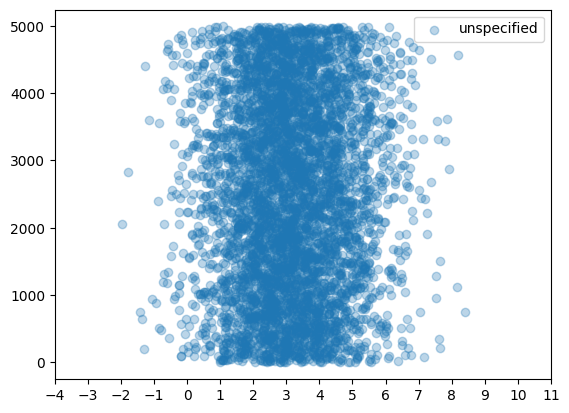

Mean of logp:  tensor(3.1320)
Std of logp:  tensor(1.4475)
Max of logp:  tensor(8.3947)
Min of logp:  tensor(-1.9574)


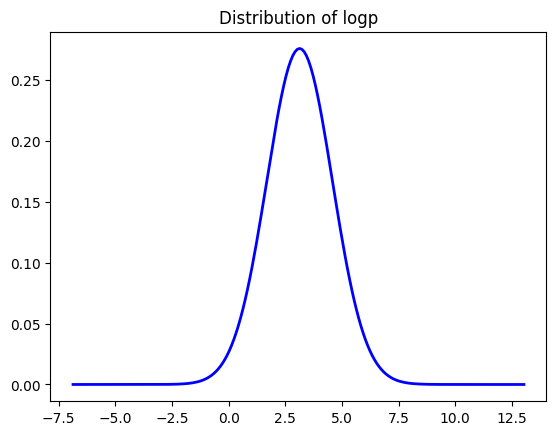

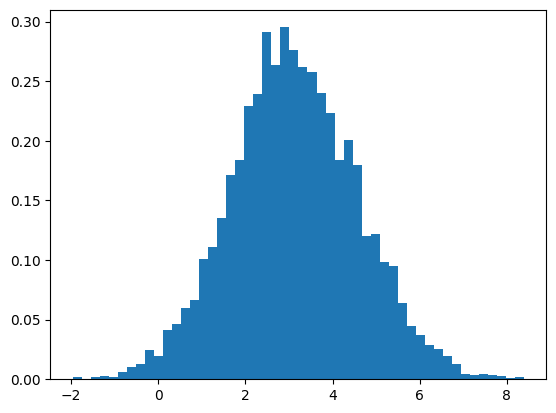

In [4]:
fname = '../log/eval_gtp2_5000000_dm_9_0.9.log'
# fname = '../log/eval_gtp2_13000000_dm_0_0.9.log'
ex = []
logp_test(fname, 'C0', 'unspecified', ex, 2)

[10:36:57] SMILES Parse Error: unclosed ring for input: 'CN1CCN(N(N)c2cc3n(n2)CCN(C2C(N)C(COCCN)C3)CC3)CC1'
[10:36:57] Explicit valence for atom # 10 N, 4, is greater than permitted
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 12
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 11
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 9 14 15
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
[10:36:57] SMILES Parse Error: unclosed ring for input: 'O=C(CN1CCNC1=O)Nc1ccc2[nH]c(=O)n3nc(C(=O)N4CC[NH3+])nc3c2c1'
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 2 4 5
[10:36:57] SMILES Parse Error: extra close parentheses while parsing: CCOC(C)(CO)[IH+])C(=O)N1CCOCC1
[10:36:57] SMILES Parse Error: Failed parsing SMILES 'CCOC(C)(CO)[IH+])C(=O)N1CCOCC1' for input: 'CCOC(C)(CO)[IH+])C(=O)N1CCOCC1'
[10:36:57] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 10 12 13
[10:36:58] Can't kekulize mol.  Unkekulized ato

Total num: 5000
Valid num: 4915, valid ratio: 0.983
Novel num: 4664, Novel ratio: 0.9328
Valid&unique num: 4483, valid&unique num ratio: 0.8966
Succes ratio of logp: 0.6541


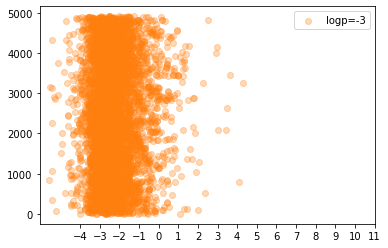

Mean of logp:  tensor(-2.2780)
Std of logp:  tensor(1.0191)
Max of logp:  tensor(4.3117)
Min of logp:  tensor(-5.5735)


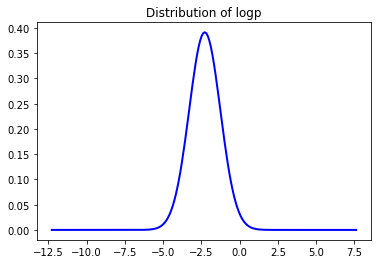

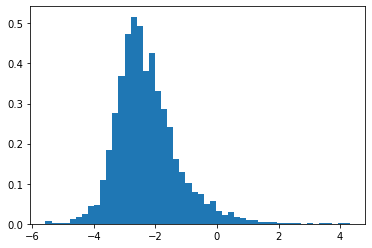

In [7]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_m3.log'
logp_test(fname, 'C1', 'logp=-3', ex, -3)

[10:49:26] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 16 17
[10:49:26] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:49:26] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 16
[10:49:26] Can't kekulize mol.  Unkekulized atoms: 19
[10:49:26] Explicit valence for atom # 8 N, 5, is greater than permitted
[10:49:26] Can't kekulize mol.  Unkekulized atoms: 23
[10:49:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 11 12 13 14 15 16
[10:49:27] SMILES Parse Error: unclosed ring for input: 'O=C1Cc2c(O)ccc3c2C(=O)C(O)(O)C(O)C3O'
[10:49:27] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 16 18
[10:49:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 13 14 15
[10:49:27] Can't kekulize mol.  Unkekulized atoms: 2 3 17 19 20
[10:49:27] Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15 16 17
[10:49:27] Can't kekulize mol.  Unkekulized atoms: 11
[10:49:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14
[10:49:28] Can't kekulize mol.  Unk

Total num: 5000
Valid num: 4966, valid ratio: 0.9932
Novel num: 4781, Novel ratio: 0.9562
Valid&unique num: 4880, valid&unique num ratio: 0.976
Succes ratio of logp: 0.9247


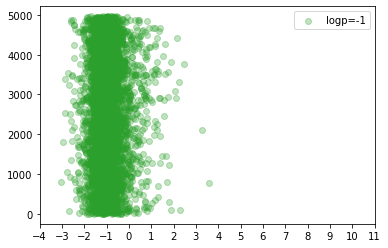

Mean of logp:  tensor(-0.9892)
Std of logp:  tensor(0.5859)
Max of logp:  tensor(3.5701)
Min of logp:  tensor(-3.0589)


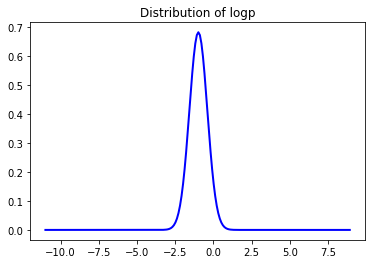

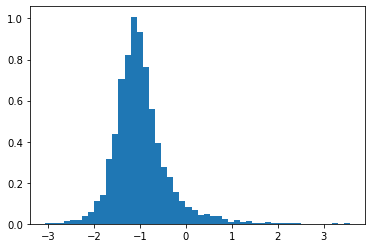

In [8]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9.log'
# fname = '../log/eval_gtp2_13000000_dm_0_0.9.log'
logp_test(fname, 'C2', 'logp=-1', ex, -1)

[11:01:47] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8
[11:01:47] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 11 12 14
[11:01:48] Explicit valence for atom # 21 O, 3, is greater than permitted
[11:01:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 16
[11:01:48] SMILES Parse Error: unclosed ring for input: 'CC1CCCCC12NC(=O)N(CC(=O)NCC1CN(C)CCN1C(C)CCCC1)C2=O'
[11:01:49] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17 18 22
[11:01:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[11:01:49] SMILES Parse Error: unclosed ring for input: 'O=C1CCn2c3c(c4cc(F)ccc42)CCNCC3'
[11:01:49] Can't kekulize mol.  Unkekulized atoms: 11 12 14 15 16 17 18 19 29 30 31
[11:01:49] SMILES Parse Error: extra close parentheses while parsing: CC(C)NC(=O)Nc1cccc(C2OC(CSc3nnnn3C)C(C)C(c3ccc(CO)cc3)O2)c1)>(=O)[O-]
[11:01:49] SMILES Parse Error: Failed parsing SMILES 'CC(C)NC(=O)Nc1cccc(C2OC(CSc3nnnn3C)C(C)C(c3ccc(CO)cc3)O2)c1)>(=O)[O-]' for input: 'CC(C)NC(=O)

Total num: 5000
Valid num: 4988, valid ratio: 0.9976
Novel num: 4808, Novel ratio: 0.9616
Valid&unique num: 4973, valid&unique num ratio: 0.9946
Succes ratio of logp: 0.9348


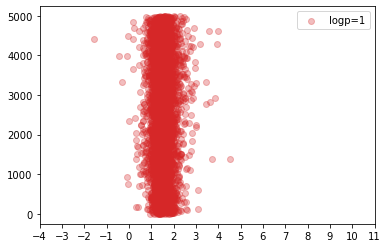

Mean of logp:  tensor(1.5034)
Std of logp:  tensor(0.3529)
Max of logp:  tensor(4.5292)
Min of logp:  tensor(-1.5470)


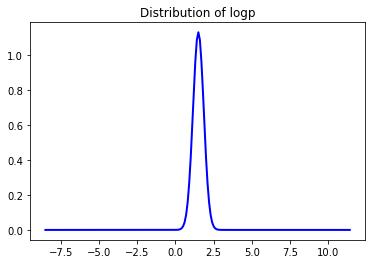

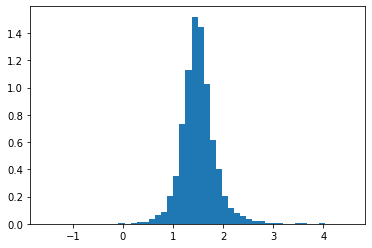

In [9]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_1.log'
logp_test(fname, 'C3', 'logp=1', ex, 1)

[11:11:20] SMILES Parse Error: extra close parentheses while parsing: N#Cc1cc(C(F)F)c(CN)nc1OC(F)(F)F)c(Cl)n1
[11:11:20] SMILES Parse Error: Failed parsing SMILES 'N#Cc1cc(C(F)F)c(CN)nc1OC(F)(F)F)c(Cl)n1' for input: 'N#Cc1cc(C(F)F)c(CN)nc1OC(F)(F)F)c(Cl)n1'
[11:11:21] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 27
[11:11:21] SMILES Parse Error: unclosed ring for input: 'Cc1noc(C2CC(O)CN2Cc2cccc3ccc4cccc5[nH]c(C)c2c45)n1'
[11:11:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11 12 13 14 16 17 19
[11:11:23] SMILES Parse Error: unclosed ring for input: 'CN(C)C1(c2ccccc2)CCC2(CC1)CN(c1cnc(-c3ccncn3)cn1)C(=O)N2CC1CC1(O)CC1'
[11:11:23] SMILES Parse Error: unclosed ring for input: 'O=C(C=Cc1ccc(Cl)cc1)Nc1ccc2c(c1)C(=O)C1C3C(=O)NC(=O)C3C2'
[11:11:23] SMILES Parse Error: unclosed ring for input: 'CNC1CCN(c2ccc3oc4ccc5c6c(ccc(c46)c3c2)C(=O)N(C2CCC(=O)N2)C3=O)CC1'


Total num: 5000
Valid num: 4993, valid ratio: 0.9986
Novel num: 4880, Novel ratio: 0.976
Valid&unique num: 4988, valid&unique num ratio: 0.9976
Succes ratio of logp: 0.9577


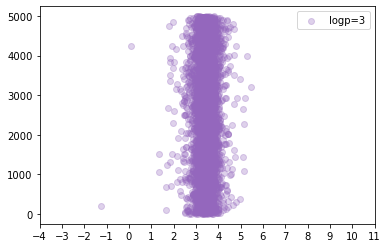

Mean of logp:  tensor(3.4386)
Std of logp:  tensor(0.3447)
Max of logp:  tensor(5.4857)
Min of logp:  tensor(-1.2395)


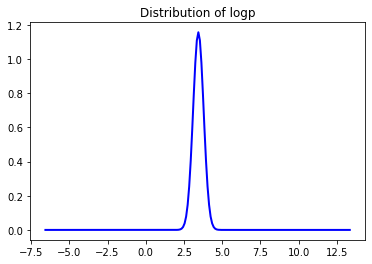

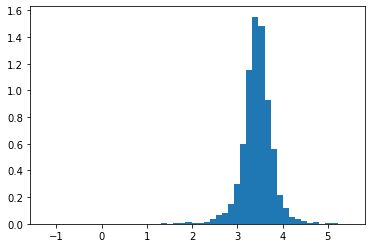

In [10]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_3.log'
logp_test(fname, 'C4', 'logp=3', ex, 3)

[11:20:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10 11 12 13 20 21 22
[11:20:36] Can't kekulize mol.  Unkekulized atoms: 7 8 21 22 23 24 25 28 29
[11:20:38] Can't kekulize mol.  Unkekulized atoms: 5 6 13
[11:20:39] Can't kekulize mol.  Unkekulized atoms: 2 10 15 16 17 18 24
[11:20:39] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[11:20:39] SMILES Parse Error: unclosed ring for input: 'CCCc1cc2[nH]c(C)c3c(=O)n(CCCC(=O)c4ccc(Cl)cc4)nc1-2'
[11:20:40] SMILES Parse Error: unclosed ring for input: 'O=[N+]([O-])c1ccc(N2N=C3c4ccccc4-c4cccc3C3C=CCC32)cc1'
[11:20:40] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26


Total num: 5000
Valid num: 4992, valid ratio: 0.9984
Novel num: 4901, Novel ratio: 0.9802
Valid&unique num: 4991, valid&unique num ratio: 0.9982
Succes ratio of logp: 0.9413


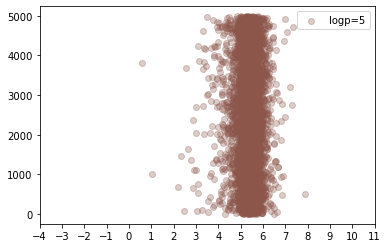

Mean of logp:  tensor(5.3755)
Std of logp:  tensor(0.4488)
Max of logp:  tensor(7.8769)
Min of logp:  tensor(0.5957)


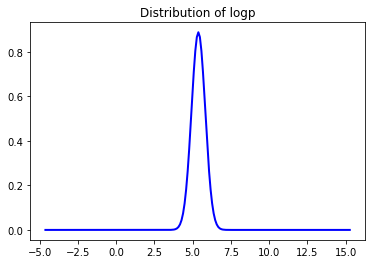

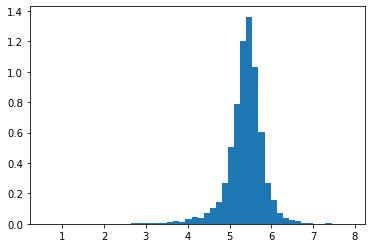

In [11]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_5.log'
logp_test(fname, 'C5', 'logp=5', ex, 5)

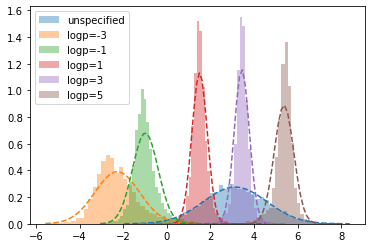

In [45]:
for data in ex:
    u = data['u']
    sigma = data['sigma']
    bins = data['bins']
    logps = data['logps']
    color = data['color']
    label = data['label']

    bins_y_dm = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - u))**2))
    plt.plot(bins, bins_y_dm, '--', color=color)
    plt.hist(logps, bins=50, label=label, alpha=0.4, density=True, color=color)

plt.legend()
plt.savefig('../fig/dl_hist.png', bbox_inches='tight')
plt.savefig('../fig/dl_hist.svg', bbox_inches='tight')
plt.show()

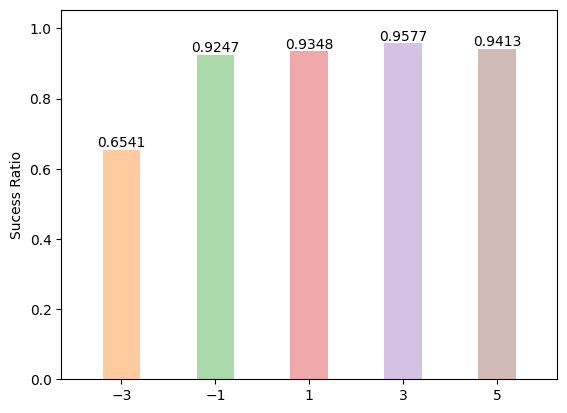

In [5]:
x = [-3,-1,1,3,5]
bar_colors = ['C1','C2','C3','C4','C5']
# bar_labels = ['LogP=-3']
y = [0.6541,0.9247,0.9348,0.9577,0.9413]

fig, ax = plt.subplots()
rects = ax.bar(x,y,color=bar_colors,alpha=0.4)
ax.bar_label(rects)
ax.set_ylabel("Sucess Ratio")
plt.xticks(x)
plt.margins(0.1)
plt.savefig('../fig/dl_bar.png', bbox_inches='tight')
plt.savefig('../fig/dl_bar.svg', bbox_inches='tight')

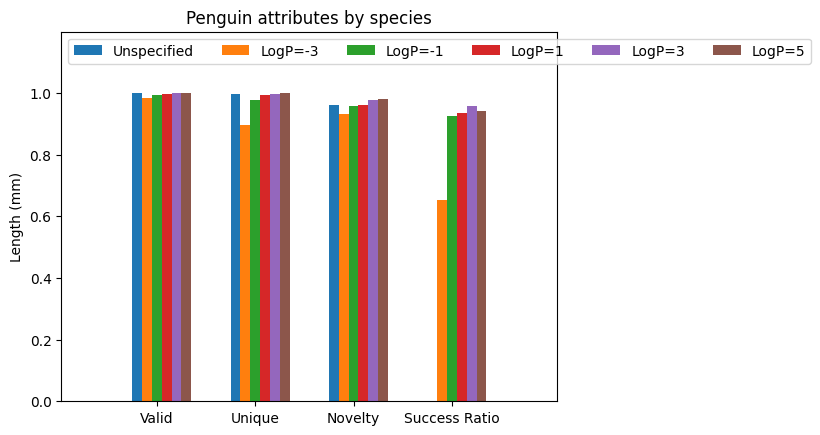

In [25]:
species = ("Valid","Unique","Novelty","Success Ratio")
matrices = {
    'Unspecified':(0.9982, 0.9974, 0.9606, 0),
    'LogP=-3':(0.9830, 0.8966, 0.9328, 0.6541),
    'LogP=-1':(0.9932, 0.976, 0.9562, 0.9247),
    'LogP=1':(0.9976, 0.9946, 0.9616, 0.9348),
    'LogP=3':(0.9986, 0.9976, 0.976, 0.9577),
    'LogP=5':(0.9984, 0.9982, 0.9802, 0.9413)
}
x = np.arange(len(species))  # the label locations
# print(x)
width = 0.1  # the width of the bars
multiplier = -1

fig, ax = plt.subplots()

for attribute, measurement in matrices.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=6)
plt.margins(0.2)
# ax.legend(loc='upper left')
# ax.set_ylim(0, 250)

plt.show()

[15:17:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 8 9 12
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 12 15 17 21 23
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 2
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 1 2 12
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 6
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 4
[15:17:41] SMILES Parse Error: unclosed ring for input: 'O=C(Cn1cnnn1)NCC(=O)NC1C(=O)NC1SC1=O'
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 20 21 28
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 1 2 6 7 16 18 19
[15:17:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[15:17:41] Can't kekulize mol.  Unkekulized atoms: 3 4 16 17 18
[15:17:41] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:17:41] Explicit valence for atom # 11 C, 5,

Total num: 5000
Valid num: 4938, valid ratio: 0.9876
Novel num: 4723, Novel ratio: 0.9446
Valid&unique num: 4627, valid&unique num ratio: 0.9254
Succes ratio of logp: 0.13


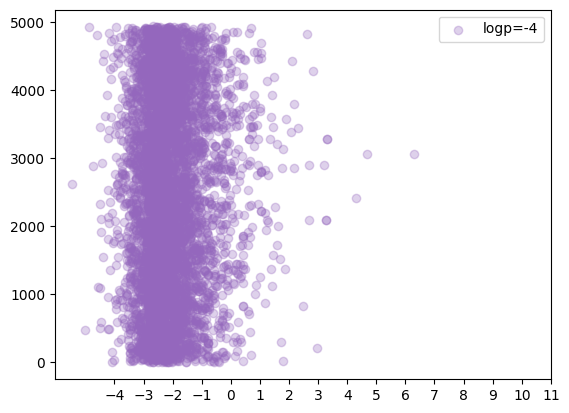

Mean of logp:  tensor(-2.0818)
Std of logp:  tensor(0.9929)
Max of logp:  tensor(6.2887)
Min of logp:  tensor(-5.4619)


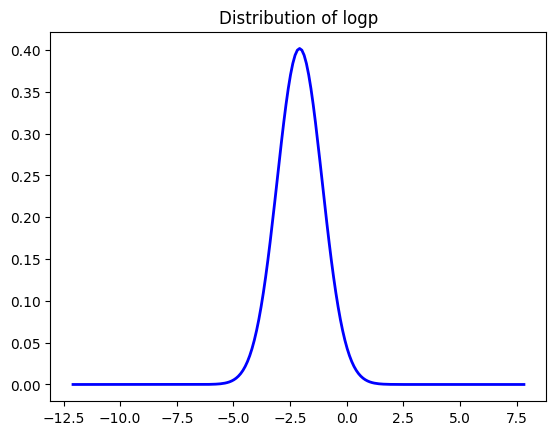

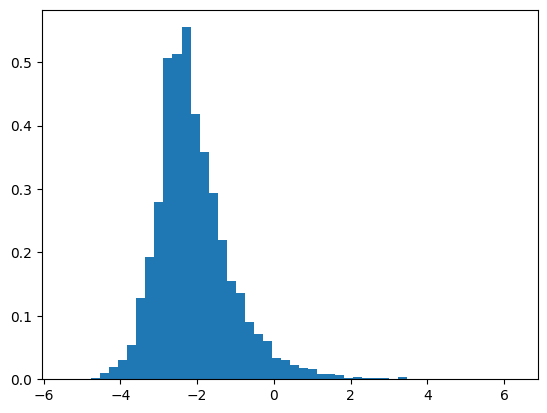

In [7]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_m4.log'
ex = []
logp_test(fname, 'C4', 'logp=-4', ex, -4)

[15:08:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8
[15:08:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 24
[15:08:30] Can't kekulize mol.  Unkekulized atoms: 2 3 12 14 15
[15:08:31] SMILES Parse Error: unclosed ring for input: 'CNc1cc2c3c(ncn3C)-c3c(=O)n(CC(N)=O)c(=O)n(C)c3CC2O'
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 2
[15:08:31] SMILES Parse Error: unclosed ring for input: 'NC(=O)N1Cc2ccccc2C1C(=O)N(N)CC1(O)NC1=CC=C(N)CC1'
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 2 3 8 10
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 14
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 13 15 16 17 18 21 22 23 24
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 11 12 15
[15:08:31] Can't kekulize mol.  Unkekulized atoms: 5 6 19
[15:08:31

Total num: 5000
Valid num: 4955, valid ratio: 0.991
Novel num: 4753, Novel ratio: 0.9506
Valid&unique num: 4876, valid&unique num ratio: 0.9752
Succes ratio of logp: 0.0


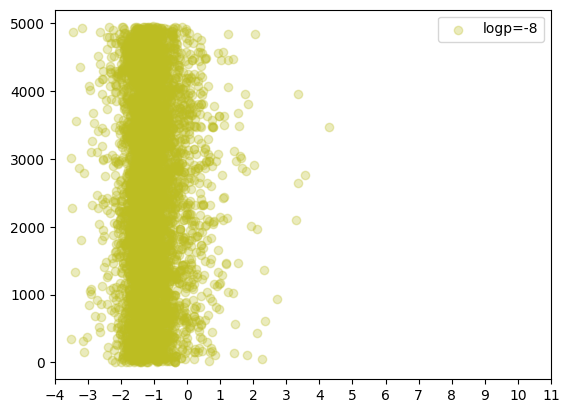

Mean of logp:  tensor(-1.0738)
Std of logp:  tensor(0.6540)
Max of logp:  tensor(4.3038)
Min of logp:  tensor(-3.5122)


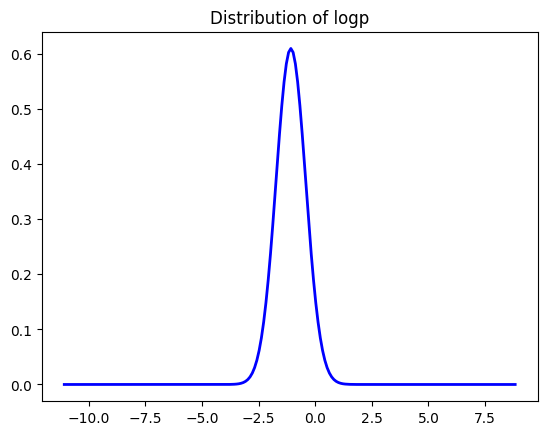

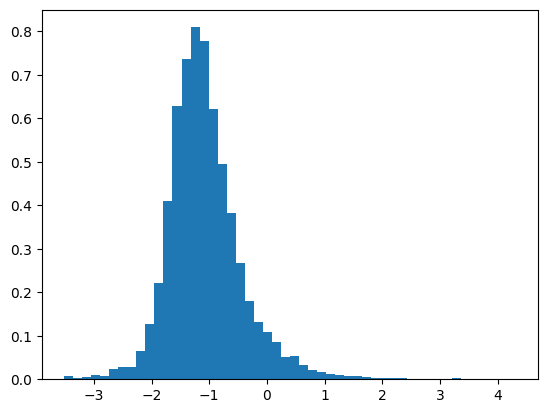

In [6]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_m8.log'
ex = []
logp_test(fname, 'C8', 'logp=-8', ex, -8)

[19:12:08] Explicit valence for atom # 13 N, 4, is greater than permitted
[19:12:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 23 24
[19:12:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[19:12:09] SMILES Parse Error: unclosed ring for input: 'CC1=CC(C)=NC(=O)c2c(NC(=O)c3cc(C)[nH]n3)sc3c21'
[19:12:09] SMILES Parse Error: unclosed ring for input: 'CC(=O)Nc1ccc(-c2cc3c(nc(N4CCN(C)CC4)nc3n3nc(C)cc23)CCC3)cc1'
[19:12:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
[19:12:10] SMILES Parse Error: unclosed ring for input: 'C1CC2CC3C2C1'
[19:12:10] SMILES Parse Error: unclosed ring for input: 'c1c2ccc3occ-2[n+](-c2ccc4c(c2)OCO4)c1-c1ccco1'
[19:12:10] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[19:12:10] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 10 11 12 13 14
[19:12:10] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16 17 18 19 20
[19:12:10] Can't kekulize mol.  Unkekulized atoms: 11 15 16 17 18 20 21
[19:12:10] C

Total num: 5000
Valid num: 4958, valid ratio: 0.9916
Novel num: 4511, Novel ratio: 0.9022
Valid&unique num: 4858, valid&unique num ratio: 0.9716
Succes ratio of logp: 0.0


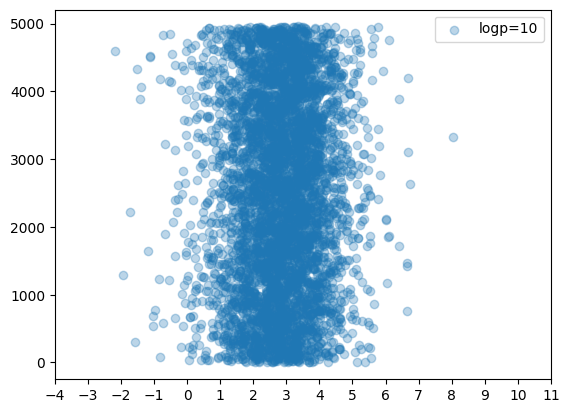

Mean of logp:  tensor(2.8054)
Std of logp:  tensor(1.0899)
Max of logp:  tensor(8.0490)
Min of logp:  tensor(-2.1914)


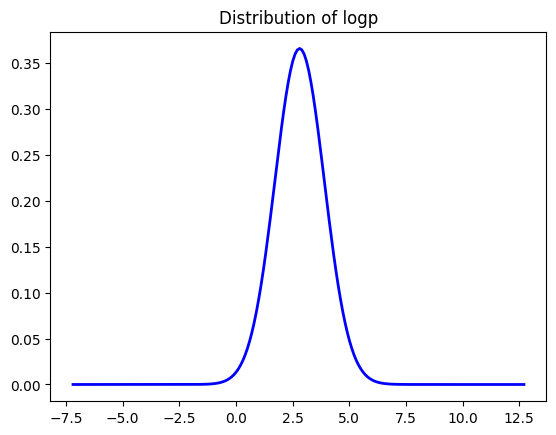

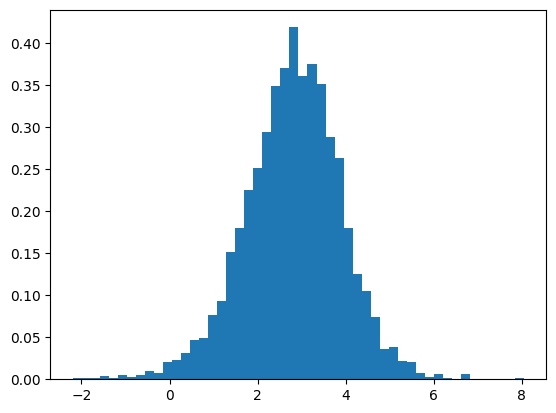

In [9]:
fname = '../log/eval_gtp2_5000000_dl_9_0.9_10.log'
ex = []
logp_test(fname, 'C10', 'logp=10', ex, 10)

# sas test

In [ ]:
# fname = '../log/eval_gtp2_5000000_dm_9_0.9.log'
fname = '../log/eval_gtp2_13000000_dm_0_0.9.log'
nums_dm, valid_num_dm, unique_num_dm, equal_num_dm, valid_unique_num_dm, sass_dm = matrix_sa(fname)

In [ ]:
print(f"Total num: {nums_dm}")
print(f"Valid num: {valid_num_dm}, valid ratio: {valid_num_dm/nums_dm}")
print(f"Unique num: {unique_num_dm}, unique ratio: {unique_num_dm/nums_dm}")
print(f"Equal num: {equal_num_dm}, equal ratio: {equal_num_dm/nums_dm}")
print(f"Valid&unique num: {valid_unique_num_dm}, valid&unique num ratio: {valid_unique_num_dm/nums_dm}")

In [ ]:
x = sass_dm
y = [i for i in range(len(x))]

plt.scatter(x, y, label='unspecified')
plt.legend()
plt.xticks([i for i in range(0,6)])
plt.savefig('../fig/dm_scatter_sas.png', bbox_inches='tight')
plt.show()

In [ ]:
sass_dm_list = torch.Tensor(sass_dm)

print('Mean of sas: ', sass_dm_list.mean())
print('Std of sas: ', sass_dm_list.std())
print('Max of sas: ', sass_dm_list.max())
print('Min of sas: ', sass_dm_list.min())

u_dm_s = sass_dm_list.mean().item()
sigma_dm_s = sass_dm_list.std().item()
x_dm_s = np.arange(u_dm_s - 10, u_dm_s + 10, 0.1)
y_dm_s = gd(x_dm_s, u_dm_s, sigma_dm_s)

plt.subplot(111)
plt.plot(x_dm_s, y_dm_s, 'b-', linewidth=2)
plt.title("Distribution of sas")
plt.show()

In [ ]:
fname = '../log/eval_gtp2_5000000_ds_9_0.9_poor.log'
# fname = '../log/eval_gtp2_13000000_ds_0_0.9.log'
nums_ds, valid_num_ds, unique_num_ds, equal_num_ds, valid_unique_num_ds, sass_ds = matrix_sa(fname)

In [ ]:
print(f"Total num: {nums_ds}")
print(f"Valid num: {valid_num_ds}, valid ratio: {valid_num_ds/nums_ds}")
print(f"Unique num: {unique_num_ds}, unique ratio: {unique_num_ds/nums_ds}")
print(f"Equal num: {equal_num_ds}, equal ratio: {equal_num_ds/nums_ds}")
print(f"Valid&unique num: {valid_unique_num_ds}, valid&unique num ratio: {valid_unique_num_ds/nums_ds}")

In [ ]:
x = sass_ds
y = [i for i in range(len(x))]

plt.scatter(x, y, label='SAs = 1')
plt.legend()
plt.xticks([i for i in range(0,6)])
plt.savefig('../fig/ds_scatter.png', bbox_inches='tight')
plt.show()

In [ ]:
sass_ds_list = torch.Tensor(sass_ds)

print('Mean of sas: ', sass_ds_list.mean())
print('Std of sas: ', sass_ds_list.std())
print('Max of sas: ', sass_ds_list.max())
print('Min of sas: ', sass_ds_list.min())

u_ds = sass_ds_list.mean().item()
sigma_ds = sass_ds_list.std().item()
x_ds = np.arange(u_ds - 10, u_ds + 10, 0.1)
y_ds = gd(x_ds, u_ds, sigma_ds)


plt.subplot(111)
plt.plot(x_dm_s, y_dm_s, 'b-', linewidth=2)
plt.plot(x_ds, y_ds, 'r', linewidth=2)
# plt.ylim(0,10)
# plt.xticks([i for i in range(-8,13)])
plt.title("Distribution of SAs")
plt.savefig('../fig/distribution_of_sas.png', bbox_inches='tight')
plt.show()